## End-To-End Dialogue System
### Matt Hawrot | QMUL |m.g.hawrot@se20.qmul.ac.uk


In [ ]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")

Mounted at /content/drive


In [ ]:
!unzip cornell_movie_dialogs_corpus

Archive:  cornell_movie_dialogs_corpus.zip
replace cornell movie-dialogs corpus/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [ ]:
#Loading the data
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [ ]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [ ]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [ ]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [ ]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

In [ ]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [ ]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [ ]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [ ]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        #  pass the embedding into a bidirectional version of the GRU
        self.embeddings = embeddings
        self.Bidirectional1 = Bidirectional(GRU(embedding_dim))
        #self.Bidirectional2 = Bidirectional(GRU(embedding_dim))
        self.Bidirectional2 = Bidirectional(GRU(self.enc_units, return_sequences=True, 
                               return_state=True, recurrent_initializer='glorot_uniform'))
                                                                                      
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
       # x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [ ]:
encoder = Encoder(vocab_len, 50, GRU_units)


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.dropout = Dropout(0.4)
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # Cretae the decoder with attention
        self.decoder_gru_l1 = GRU(self.units, return_sequences=True, 
                                  return_state= False, recurrent_initializer='glorot_uniform' ,name='decoder_gru1' )
        self.decoder_gru_l2 = GRU(self.units, return_sequences=False, 
                                  return_state= True, recurrent_initializer='glorot_uniform' ,name='decoder_gru2')
        self.attention = BahdanauAttention(dec_units)

        
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_len, 50, GRU_units)


# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [ ]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [ ]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [ ]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 114
EPOCHS = 1000 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 121


We are creating a test_bot to monitor our training in every time step.

In [ ]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 121 Batch 598 Loss: 1.4618
Epoch 121 Batch 1196 Loss: 1.6885
Epoch 121 Batch 1794 Loss: 1.6724
Epoch 121 Batch 2392 Loss: 1.7184
Epoch 121 Batch 2990 Loss: 1.4687
Epoch 121 Batch 3588 Loss: 1.4603

*** Epoch 121 Loss 1.5644 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am learning 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go to me 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  121
Time  140.639 sec

Epoch 122 Batch 598 Loss: 1.4678
Epoch 122 Batch 1196 Loss: 1.8428
Epoch 122 Batch 1794 Loss: 1.9342
Epoch 122 Batch 2392 Loss: 1.9652
Epoch 122 Batch 2990 Loss: 1.4909
Epoch 122 Batch 3588 Loss: 1.7777

*** Epoch 122 Loss 1.5168 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going t

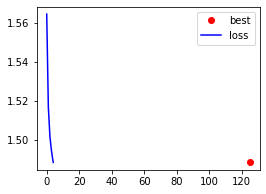

Best epoch so far:  125
Time  137.553 sec

Epoch 126 Batch 598 Loss: 1.3548
Epoch 126 Batch 1196 Loss: 1.6550
Epoch 126 Batch 1794 Loss: 1.5514
Epoch 126 Batch 2392 Loss: 1.6996
Epoch 126 Batch 2990 Loss: 1.3782
Epoch 126 Batch 3588 Loss: 1.4625

*** Epoch 126 Loss 1.4849 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  126
Time  140.212 sec

Epoch 127 Batch 598 Loss: 1.4993
Epoch 127 Batch 1196 Loss: 1.8408
Epoch 127 Batch 1794 Loss: 1.8483
Epoch 127 Batch 2392 Loss: 1.9384
Epoch 127 Batch 2990 Loss: 1.3637
Epoch 127 Batch 3588 Loss: 1.6951

*** Epoch 127 Loss 1.4829 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?

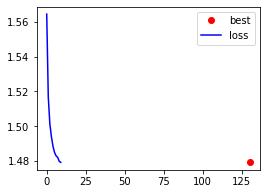

Best epoch so far:  130
Time  135.207 sec

Epoch 131 Batch 598 Loss: 1.3716
Epoch 131 Batch 1196 Loss: 1.6727
Epoch 131 Batch 1794 Loss: 1.4996
Epoch 131 Batch 2392 Loss: 1.7361
Epoch 131 Batch 2990 Loss: 1.3764
Epoch 131 Batch 3588 Loss: 1.5461

*** Epoch 131 Loss 1.4779 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  131
Time  136.680 sec

Epoch 132 Batch 598 Loss: 1.4978
Epoch 132 Batch 1196 Loss: 1.8215
Epoch 132 Batch 1794 Loss: 1.7444
Epoch 132 Batch 2392 Loss: 1.9239
Epoch 132 Batch 2990 Loss: 1.3116
Epoch 132 Batch 3588 Loss: 1.6179

*** Epoch 132 Loss 1.4779 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?

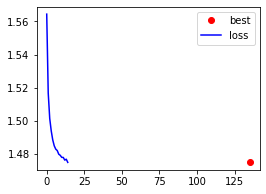

Best epoch so far:  135
Time  137.143 sec

Epoch 136 Batch 598 Loss: 1.3071
Epoch 136 Batch 1196 Loss: 1.7300
Epoch 136 Batch 1794 Loss: 1.5277
Epoch 136 Batch 2392 Loss: 1.7831
Epoch 136 Batch 2990 Loss: 1.4386
Epoch 136 Batch 3588 Loss: 1.5248

*** Epoch 136 Loss 1.4752 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to yell 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  135
Time  135.681 sec

Epoch 137 Batch 598 Loss: 1.3879
Epoch 137 Batch 1196 Loss: 1.6188
Epoch 137 Batch 1794 Loss: 1.5698
Epoch 137 Batch 2392 Loss: 1.6691
Epoch 137 Batch 2990 Loss: 1.3820
Epoch 137 Batch 3588 Loss: 1.3468

*** Epoch 137 Loss 1.4744 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am 

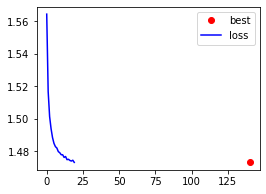

Best epoch so far:  140
Time  137.702 sec

Epoch 141 Batch 598 Loss: 1.2780
Epoch 141 Batch 1196 Loss: 1.8138
Epoch 141 Batch 1794 Loss: 1.6713
Epoch 141 Batch 2392 Loss: 1.8106
Epoch 141 Batch 2990 Loss: 1.4913
Epoch 141 Batch 3588 Loss: 1.6908

*** Epoch 141 Loss 1.4732 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  141
Time  134.832 sec

Epoch 142 Batch 598 Loss: 1.3484
Epoch 142 Batch 1196 Loss: 1.6515
Epoch 142 Batch 1794 Loss: 1.5462
Epoch 142 Batch 2392 Loss: 1.6849
Epoch 142 Batch 2990 Loss: 1.3397
Epoch 142 Batch 3588 Loss: 1.4722

*** Epoch 142 Loss 1.4724 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: W

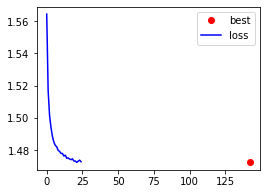

Best epoch so far:  142
Time  138.110 sec

Epoch 146 Batch 598 Loss: 1.3519
Epoch 146 Batch 1196 Loss: 1.8877
Epoch 146 Batch 1794 Loss: 1.8070
Epoch 146 Batch 2392 Loss: 1.7305
Epoch 146 Batch 2990 Loss: 1.5482
Epoch 146 Batch 3588 Loss: 1.7687

*** Epoch 146 Loss 1.4722 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  146
Time  134.056 sec

Epoch 147 Batch 598 Loss: 1.3783
Epoch 147 Batch 1196 Loss: 1.6764
Epoch 147 Batch 1794 Loss: 1.4875
Epoch 147 Batch 2392 Loss: 1.7440
Epoch 147 Batch 2990 Loss: 1.3674
Epoch 147 Batch 3588 Loss: 1.5237

*** Epoch 147 Loss 1.4715 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?

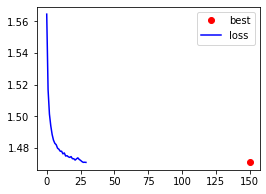

Best epoch so far:  150
Time  137.836 sec

Epoch 151 Batch 598 Loss: 1.2147
Epoch 151 Batch 1196 Loss: 2.0291
Epoch 151 Batch 1794 Loss: 1.7628
Epoch 151 Batch 2392 Loss: 1.8289
Epoch 151 Batch 2990 Loss: 1.5441
Epoch 151 Batch 3588 Loss: 1.7680

*** Epoch 151 Loss 1.4707 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  151
Time  133.551 sec

Epoch 152 Batch 598 Loss: 1.3069
Epoch 152 Batch 1196 Loss: 1.7319
Epoch 152 Batch 1794 Loss: 1.5091
Epoch 152 Batch 2392 Loss: 1.7815
Epoch 152 Batch 2990 Loss: 1.4440
Epoch 152 Batch 3588 Loss: 1.5375

*** Epoch 152 Loss 1.4709 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you 

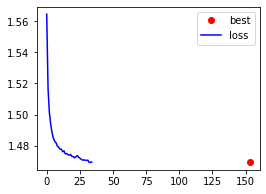

Best epoch so far:  153
Time  138.777 sec

Epoch 156 Batch 598 Loss: 1.2531
Epoch 156 Batch 1196 Loss: 2.0558
Epoch 156 Batch 1794 Loss: 1.7582
Epoch 156 Batch 2392 Loss: 1.8178
Epoch 156 Batch 2990 Loss: 1.5506
Epoch 156 Batch 3588 Loss: 1.6870

*** Epoch 156 Loss 1.4708 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to yell 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  153
Time  135.014 sec

Epoch 157 Batch 598 Loss: 1.2835
Epoch 157 Batch 1196 Loss: 1.8039
Epoch 157 Batch 1794 Loss: 1.6643
Epoch 157 Batch 2392 Loss: 1.7955
Epoch 157 Batch 2990 Loss: 1.5077
Epoch 157 Batch 3588 Loss: 1.6702

*** Epoch 157 Loss 1.4696 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am 

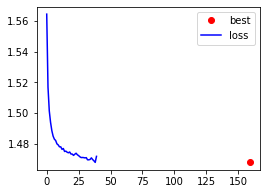

Best epoch so far:  159
Time  138.268 sec

Epoch 161 Batch 598 Loss: 1.3064
Epoch 161 Batch 1196 Loss: 1.9906
Epoch 161 Batch 1794 Loss: 1.9176
Epoch 161 Batch 2392 Loss: 1.8343
Epoch 161 Batch 2990 Loss: 1.5445
Epoch 161 Batch 3588 Loss: 1.7386

*** Epoch 161 Loss 1.4703 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  159
Time  135.232 sec

Epoch 162 Batch 598 Loss: 1.3304
Epoch 162 Batch 1196 Loss: 1.8789
Epoch 162 Batch 1794 Loss: 1.8484
Epoch 162 Batch 2392 Loss: 1.7415
Epoch 162 Batch 2990 Loss: 1.5478
Epoch 162 Batch 3588 Loss: 1.7446

*** Epoch 162 Loss 1.4713 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A

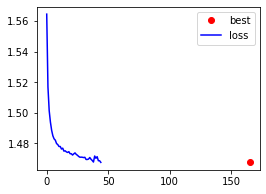

Best epoch so far:  165
Time  139.933 sec

Epoch 166 Batch 598 Loss: 1.3575
Epoch 166 Batch 1196 Loss: 1.9336
Epoch 166 Batch 1794 Loss: 1.8571
Epoch 166 Batch 2392 Loss: 1.8004
Epoch 166 Batch 2990 Loss: 1.4957
Epoch 166 Batch 3588 Loss: 1.7840

*** Epoch 166 Loss 1.4685 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  165
Time  134.695 sec

Epoch 167 Batch 598 Loss: 1.2117
Epoch 167 Batch 1196 Loss: 2.0363
Epoch 167 Batch 1794 Loss: 1.7715
Epoch 167 Batch 2392 Loss: 1.8128
Epoch 167 Batch 2990 Loss: 1.5318
Epoch 167 Batch 3588 Loss: 1.7644

*** Epoch 167 Loss 1.4699 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going

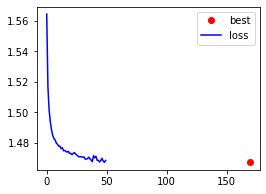

Best epoch so far:  169
Time  138.851 sec

Epoch 171 Batch 598 Loss: 1.3855
Epoch 171 Batch 1196 Loss: 1.9875
Epoch 171 Batch 1794 Loss: 1.8577
Epoch 171 Batch 2392 Loss: 1.9359
Epoch 171 Batch 2990 Loss: 1.4888
Epoch 171 Batch 3588 Loss: 1.8579

*** Epoch 171 Loss 1.4666 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  171
Time  137.697 sec

Epoch 172 Batch 598 Loss: 1.2702
Epoch 172 Batch 1196 Loss: 2.0495
Epoch 172 Batch 1794 Loss: 1.7655
Epoch 172 Batch 2392 Loss: 1.8280
Epoch 172 Batch 2990 Loss: 1.5466
Epoch 172 Batch 3588 Loss: 1.7064

*** Epoch 172 Loss 1.4665 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not seen it 
%
Greedy| Q: What are

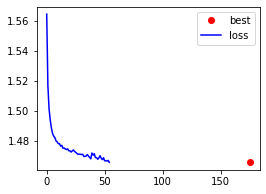

Best epoch so far:  175
Time  138.238 sec

Epoch 176 Batch 598 Loss: 1.4531
Epoch 176 Batch 1196 Loss: 1.9672
Epoch 176 Batch 1794 Loss: 1.8764
Epoch 176 Batch 2392 Loss: 1.8939
Epoch 176 Batch 2990 Loss: 1.5217
Epoch 176 Batch 3588 Loss: 1.7579

*** Epoch 176 Loss 1.4735 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  175
Time  139.748 sec

Epoch 177 Batch 598 Loss: 1.3106
Epoch 177 Batch 1196 Loss: 2.0049
Epoch 177 Batch 1794 Loss: 1.9005
Epoch 177 Batch 2392 Loss: 1.8185
Epoch 177 Batch 2990 Loss: 1.5627
Epoch 177 Batch 3588 Loss: 1.7396

*** Epoch 177 Loss 1.4673 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am no

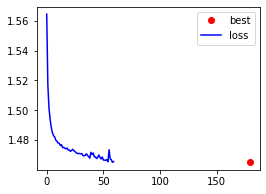

Best epoch so far:  179
Time  136.356 sec

Epoch 181 Batch 598 Loss: 1.3960
Epoch 181 Batch 1196 Loss: 1.8708
Epoch 181 Batch 1794 Loss: 1.8448
Epoch 181 Batch 2392 Loss: 1.9354
Epoch 181 Batch 2990 Loss: 1.5094
Epoch 181 Batch 3588 Loss: 1.7384

*** Epoch 181 Loss 1.4662 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not seen it 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  179
Time  139.862 sec

Epoch 182 Batch 598 Loss: 1.3714
Epoch 182 Batch 1196 Loss: 1.9623
Epoch 182 Batch 1794 Loss: 1.8536
Epoch 182 Batch 2392 Loss: 1.8018
Epoch 182 Batch 2990 Loss: 1.5111
Epoch 182 Batch 3588 Loss: 1.7759

*** Epoch 182 Loss 1.4671 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not seen it 
%
Greedy| Q: What 

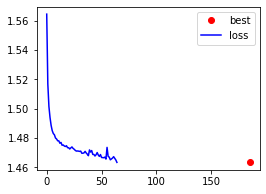

Best epoch so far:  185
Time  135.248 sec

Epoch 186 Batch 598 Loss: 1.4231
Epoch 186 Batch 1196 Loss: 1.7822
Epoch 186 Batch 1794 Loss: 1.8486
Epoch 186 Batch 2392 Loss: 1.9037
Epoch 186 Batch 2990 Loss: 1.4495
Epoch 186 Batch 3588 Loss: 1.6667

*** Epoch 186 Loss 1.4642 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  185
Time  138.457 sec

Epoch 187 Batch 598 Loss: 1.4017
Epoch 187 Batch 1196 Loss: 2.0123
Epoch 187 Batch 1794 Loss: 1.8606
Epoch 187 Batch 2392 Loss: 1.9343
Epoch 187 Batch 2990 Loss: 1.5070
Epoch 187 Batch 3588 Loss: 1.8804

*** Epoch 187 Loss 1.4647 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i 

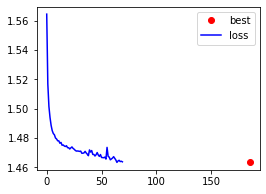

Best epoch so far:  185
Time  136.090 sec

Epoch 191 Batch 598 Loss: 1.4717
Epoch 191 Batch 1196 Loss: 1.7639
Epoch 191 Batch 1794 Loss: 1.8243
Epoch 191 Batch 2392 Loss: 1.9265
Epoch 191 Batch 2990 Loss: 1.3404
Epoch 191 Batch 3588 Loss: 1.6282

*** Epoch 191 Loss 1.4636 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not seen it 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  185
Time  139.172 sec

Epoch 192 Batch 598 Loss: 1.4218
Epoch 192 Batch 1196 Loss: 1.9286
Epoch 192 Batch 1794 Loss: 1.8351
Epoch 192 Batch 2392 Loss: 1.8901
Epoch 192 Batch 2990 Loss: 1.5163
Epoch 192 Batch 3588 Loss: 1.7590

*** Epoch 192 Loss 1.4638 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What 

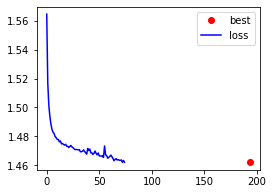

Best epoch so far:  193
Time  135.974 sec

Epoch 196 Batch 598 Loss: 1.4839
Epoch 196 Batch 1196 Loss: 1.7818
Epoch 196 Batch 1794 Loss: 1.7240
Epoch 196 Batch 2392 Loss: 1.9329
Epoch 196 Batch 2990 Loss: 1.3081
Epoch 196 Batch 3588 Loss: 1.5577

*** Epoch 196 Loss 1.4624 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  193
Time  138.655 sec

Epoch 197 Batch 598 Loss: 1.4020
Epoch 197 Batch 1196 Loss: 1.8701
Epoch 197 Batch 1794 Loss: 1.8256
Epoch 197 Batch 2392 Loss: 1.9377
Epoch 197 Batch 2990 Loss: 1.5217
Epoch 197 Batch 3588 Loss: 1.7526

*** Epoch 197 Loss 1.4648 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?

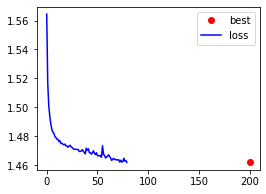

Best epoch so far:  200
Time  141.639 sec

Epoch 201 Batch 598 Loss: 1.3805
Epoch 201 Batch 1196 Loss: 1.5956
Epoch 201 Batch 1794 Loss: 1.5761
Epoch 201 Batch 2392 Loss: 1.6484
Epoch 201 Batch 2990 Loss: 1.3814
Epoch 201 Batch 3588 Loss: 1.3526

*** Epoch 201 Loss 1.4629 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  200
Time  141.987 sec

Epoch 202 Batch 598 Loss: 1.4170
Epoch 202 Batch 1196 Loss: 1.7854
Epoch 202 Batch 1794 Loss: 1.8599
Epoch 202 Batch 2392 Loss: 1.9087
Epoch 202 Batch 2990 Loss: 1.4468
Epoch 202 Batch 3588 Loss: 1.6846

*** Epoch 202 Loss 1.4638 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not seen it 
%
Greedy| Q: What are you doin

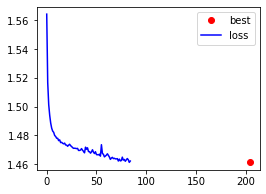

Best epoch so far:  204
Time  140.087 sec

Epoch 206 Batch 598 Loss: 1.3423
Epoch 206 Batch 1196 Loss: 1.6074
Epoch 206 Batch 1794 Loss: 1.5419
Epoch 206 Batch 2392 Loss: 1.6755
Epoch 206 Batch 2990 Loss: 1.3384
Epoch 206 Batch 3588 Loss: 1.4391

*** Epoch 206 Loss 1.4612 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  204
Time  137.773 sec

Epoch 207 Batch 598 Loss: 1.4802
Epoch 207 Batch 1196 Loss: 1.7771
Epoch 207 Batch 1794 Loss: 1.8113
Epoch 207 Batch 2392 Loss: 1.9141
Epoch 207 Batch 2990 Loss: 1.3468
Epoch 207 Batch 3588 Loss: 1.6155

*** Epoch 207 Loss 1.4632 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i 

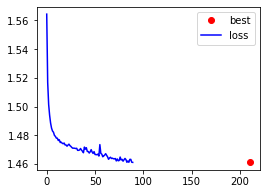

Best epoch so far:  210
Time  138.340 sec

Epoch 211 Batch 598 Loss: 1.3734
Epoch 211 Batch 1196 Loss: 1.6376
Epoch 211 Batch 1794 Loss: 1.4932
Epoch 211 Batch 2392 Loss: 1.7294
Epoch 211 Batch 2990 Loss: 1.3713
Epoch 211 Batch 3588 Loss: 1.5169

*** Epoch 211 Loss 1.4600 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not you know 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  211
Time  138.349 sec

Epoch 212 Batch 598 Loss: 1.4961
Epoch 212 Batch 1196 Loss: 1.7837
Epoch 212 Batch 1794 Loss: 1.7308
Epoch 212 Batch 2392 Loss: 1.9403
Epoch 212 Batch 2990 Loss: 1.3037
Epoch 212 Batch 3588 Loss: 1.5678

*** Epoch 212 Loss 1.4619 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: 

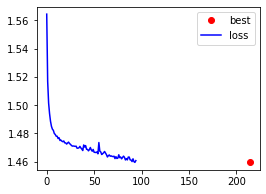

Best epoch so far:  214
Time  146.584 sec

Epoch 216 Batch 598 Loss: 1.3054
Epoch 216 Batch 1196 Loss: 1.7078
Epoch 216 Batch 1794 Loss: 1.5139
Epoch 216 Batch 2392 Loss: 1.7733
Epoch 216 Batch 2990 Loss: 1.4102
Epoch 216 Batch 3588 Loss: 1.5238

*** Epoch 216 Loss 1.4607 ***

50-ckpt
####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not seen it 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  214
Time  144.646 sec

Epoch 217 Batch 598 Loss: 1.3967
Epoch 217 Batch 1196 Loss: 1.5906
Epoch 217 Batch 1794 Loss: 1.5671
Epoch 217 Batch 2392 Loss: 1.6497
Epoch 217 Batch 2990 Loss: 1.3829
Epoch 217 Batch 3588 Loss: 1.3388

*** Epoch 217 Loss 1.4602 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: i am not you want t

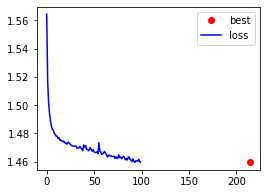

Best epoch so far:  214
Time  147.377 sec

Epoch 221 Batch 598 Loss: 1.2810
Epoch 221 Batch 1196 Loss: 1.7899
Epoch 221 Batch 1794 Loss: 1.6498
Epoch 221 Batch 2392 Loss: 1.8026
Epoch 221 Batch 2990 Loss: 1.4620
Epoch 221 Batch 3588 Loss: 1.7051

*** Epoch 221 Loss 1.4609 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am not you know 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  214
Time  147.137 sec

Epoch 222 Batch 598 Loss: 1.3616
Epoch 222 Batch 1196 Loss: 1.6131
Epoch 222 Batch 1794 Loss: 1.5295
Epoch 222 Batch 2392 Loss: 1.6863
Epoch 222 Batch 2990 Loss: 1.3344
Epoch 222 Batch 3588 Loss: 1.4180

*** Epoch 222 Loss 1.4621 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry 

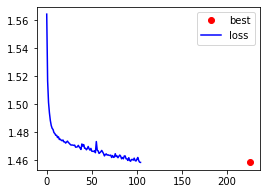

Best epoch so far:  225
Time  148.741 sec

Epoch 226 Batch 598 Loss: 1.3642
Epoch 226 Batch 1196 Loss: 1.8887
Epoch 226 Batch 1794 Loss: 1.7798
Epoch 226 Batch 2392 Loss: 1.7235
Epoch 226 Batch 2990 Loss: 1.5128
Epoch 226 Batch 3588 Loss: 1.7384

*** Epoch 226 Loss 1.4620 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am not you know 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  225
Time  145.244 sec

Epoch 227 Batch 598 Loss: 1.3563
Epoch 227 Batch 1196 Loss: 1.6297
Epoch 227 Batch 1794 Loss: 1.4787
Epoch 227 Batch 2392 Loss: 1.7173
Epoch 227 Batch 2990 Loss: 1.3589
Epoch 227 Batch 3588 Loss: 1.5296

*** Epoch 227 Loss 1.4595 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am

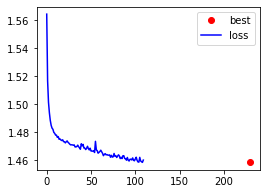

Best epoch so far:  229
Time  148.038 sec

Epoch 231 Batch 598 Loss: 1.2235
Epoch 231 Batch 1196 Loss: 2.0332
Epoch 231 Batch 1794 Loss: 1.7519
Epoch 231 Batch 2392 Loss: 1.8208
Epoch 231 Batch 2990 Loss: 1.5138
Epoch 231 Batch 3588 Loss: 1.7386

*** Epoch 231 Loss 1.4592 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to go 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  229
Time  144.648 sec

Epoch 232 Batch 598 Loss: 1.3132
Epoch 232 Batch 1196 Loss: 1.6904
Epoch 232 Batch 1794 Loss: 1.5215
Epoch 232 Batch 2392 Loss: 1.7789
Epoch 232 Batch 2990 Loss: 1.3959
Epoch 232 Batch 3588 Loss: 1.4872

*** Epoch 232 Loss 1.4578 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Gre

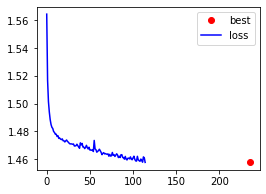

Best epoch so far:  235
Time  146.733 sec

Epoch 236 Batch 598 Loss: 1.2659
Epoch 236 Batch 1196 Loss: 2.0366
Epoch 236 Batch 1794 Loss: 1.7477
Epoch 236 Batch 2392 Loss: 1.8270
Epoch 236 Batch 2990 Loss: 1.5334
Epoch 236 Batch 3588 Loss: 1.6696

*** Epoch 236 Loss 1.4609 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am here 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  235
Time  143.712 sec

Epoch 237 Batch 598 Loss: 1.2842
Epoch 237 Batch 1196 Loss: 1.7692
Epoch 237 Batch 1794 Loss: 1.6482
Epoch 237 Batch 2392 Loss: 1.8092
Epoch 237 Batch 2990 Loss: 1.4754
Epoch 237 Batch 3588 Loss: 1.6420

*** Epoch 237 Loss 1.4594 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
G

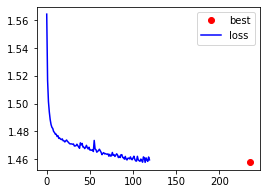

Best epoch so far:  235
Time  147.815 sec

Epoch 241 Batch 598 Loss: 1.3006
Epoch 241 Batch 1196 Loss: 1.9773
Epoch 241 Batch 1794 Loss: 1.8677
Epoch 241 Batch 2392 Loss: 1.8264
Epoch 241 Batch 2990 Loss: 1.5305
Epoch 241 Batch 3588 Loss: 1.7410

*** Epoch 241 Loss 1.4581 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  235
Time  143.533 sec

Epoch 242 Batch 598 Loss: 1.3481
Epoch 242 Batch 1196 Loss: 1.8536
Epoch 242 Batch 1794 Loss: 1.8164
Epoch 242 Batch 2392 Loss: 1.7429
Epoch 242 Batch 2990 Loss: 1.5026
Epoch 242 Batch 3588 Loss: 1.7347

*** Epoch 242 Loss 1.4606 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am

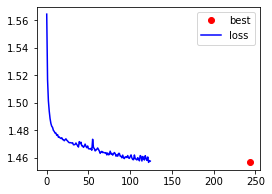

Best epoch so far:  243
Time  146.222 sec

Epoch 246 Batch 598 Loss: 1.3568
Epoch 246 Batch 1196 Loss: 1.9538
Epoch 246 Batch 1794 Loss: 1.8161
Epoch 246 Batch 2392 Loss: 1.8107
Epoch 246 Batch 2990 Loss: 1.4707
Epoch 246 Batch 3588 Loss: 1.7652

*** Epoch 246 Loss 1.4572 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am not you see 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  243
Time  146.463 sec

Epoch 247 Batch 598 Loss: 1.2186
Epoch 247 Batch 1196 Loss: 1.9974
Epoch 247 Batch 1794 Loss: 1.7484
Epoch 247 Batch 2392 Loss: 1.8234
Epoch 247 Batch 2990 Loss: 1.4937
Epoch 247 Batch 3588 Loss: 1.7649

*** Epoch 247 Loss 1.4601 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am 

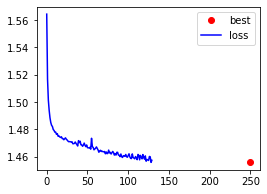

Best epoch so far:  249
Time  145.325 sec

Epoch 251 Batch 598 Loss: 1.3923
Epoch 251 Batch 1196 Loss: 1.9596
Epoch 251 Batch 1794 Loss: 1.8417
Epoch 251 Batch 2392 Loss: 1.9442
Epoch 251 Batch 2990 Loss: 1.4784
Epoch 251 Batch 3588 Loss: 1.8217

*** Epoch 251 Loss 1.4581 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  249
Time  144.912 sec

Epoch 252 Batch 598 Loss: 1.2606
Epoch 252 Batch 1196 Loss: 2.0327
Epoch 252 Batch 1794 Loss: 1.7503
Epoch 252 Batch 2392 Loss: 1.8513
Epoch 252 Batch 2990 Loss: 1.5156
Epoch 252 Batch 3588 Loss: 1.6678

*** Epoch 252 Loss 1.4584 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i a

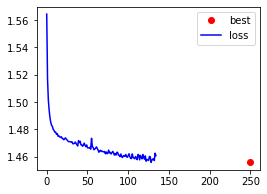

Best epoch so far:  249
Time  146.983 sec

Epoch 256 Batch 598 Loss: 1.4492
Epoch 256 Batch 1196 Loss: 1.9302
Epoch 256 Batch 1794 Loss: 1.8172
Epoch 256 Batch 2392 Loss: 1.9001
Epoch 256 Batch 2990 Loss: 1.4971
Epoch 256 Batch 3588 Loss: 1.7379

*** Epoch 256 Loss 1.4571 ***

50-ckpt
####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am not you see 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
Best epoch so far:  249
Time  145.881 sec

Epoch 257 Batch 598 Loss: 1.3141
Epoch 257 Batch 1196 Loss: 1.9958
Epoch 257 Batch 1794 Loss: 1.8880
Epoch 257 Batch 2392 Loss: 1.8330
Epoch 257 Batch 2990 Loss: 1.5153
Epoch 257 Batch 3588 Loss: 1.6888

*** Epoch 257 Loss 1.4576 ***

50-ckpt
####################
Greedy| Q: Hello   A:

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    print(checkpoint_prefix)
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [ ]:

checkpoint.restore(str(emb_dim)+"-ckpt-249")


In [ ]:
test_bot()


####################
Greedy| Q: Hello   A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: How are you ?  A: i am not you want to see you 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################


Input: how old are you
Predicted answer: thirtyfive 


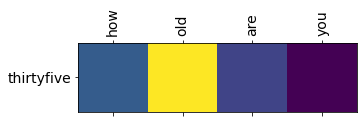

In [ ]:
q = "How old are you"
answer(q, training=False)


Input: do you drink
Predicted answer: i am not 


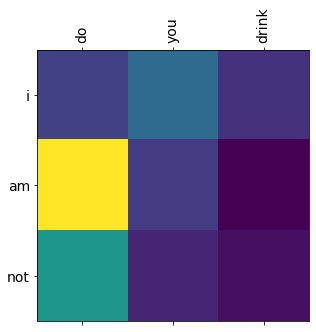

In [ ]:
q = "Do you drink"
answer(q, training=False)


**Task 3** Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following question based on your predictions.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?





















You now have a good understanding of how to build a generative conversational model. If you're interested, you can customise the chatbot's behaviour by adjusting the model and training parameters, as well as the data used to train the model.

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not you see you 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
Input: how old are you
Predicted answer: thirtyfive 


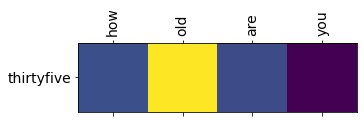

Input: do you drink
Predicted answer: i am not 


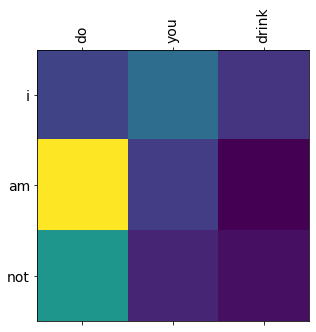

In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-269")
test_bot()
q = "How old are you"
answer(q, training=False)
q = "Do you drink"
answer(q, training=False)


In [ ]:
import sys
sys.setrecursionlimit(10**6)

In [ ]:
questions = ["How old are you", "Do you drink", "What is your favorite restaurant", "What'd he say", "What time is it", "Why not", "What's this", "What just happened", "How are you feeling", "Are you married"]


In [ ]:
def evaluate(questions):
  for ques in questions:
    answer(ques, training=False)
    print("- - - - - ")

In [ ]:
# Model after 269 epochs
checkpoint.restore(str(emb_dim)+"-ckpt-5")
evaluate(questions)


In [ ]:
# Model after 5 epochs
checkpoint.restore(str(emb_dim)+"-ckpt-5")
evaluate(questions)


In [ ]:
# Model after 50 epochs
checkpoint.restore(str(emb_dim)+"-ckpt-50")
evaluate(questions)


In [ ]:
# Model after 140 epochs
checkpoint.restore(str(emb_dim)+"-ckpt-140")
evaluate(questions)
